# OMR project

The goal of this notebook is to play around with techniques to use in order to read a musical score from an image.
We will experiment multiple techniques, evaluate what we believe is best, and move forward.

In [1]:
import sys

# Add parent directory to Python PATH in order to allow imports from utils package
[lab_path] = ! pwd
if 'notebooks' in lab_path:
    sys.path.append("../src")
else:
    sys.path.append("src")

In [2]:
import os

import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from utils.stopwatch import StopWatch
from utils.display import display_img
from utils.im_utils import otsu_bin, remove_black_blocks

In [3]:
DATA_PATH="data"
if 'notebooks' in lab_path:
    DATA_PATH = "../data"
timer = StopWatch()

In [4]:
supported_img_extensions = ["png", "jpg"]
sample_files = [file for file in os.listdir(DATA_PATH) if file[-3:] in supported_img_extensions]
sample_files

['imagine.png',
 'fire.jpg',
 'lost.jpg',
 '2020-04-11 22.16.28.jpg',
 'sheet.jpg',
 'old_town_road.png',
 'Moonlight Shadow Flauta-1.png',
 'VarnattstankarvidFridasruta.jpg',
 'races.png']

(3508, 2479)


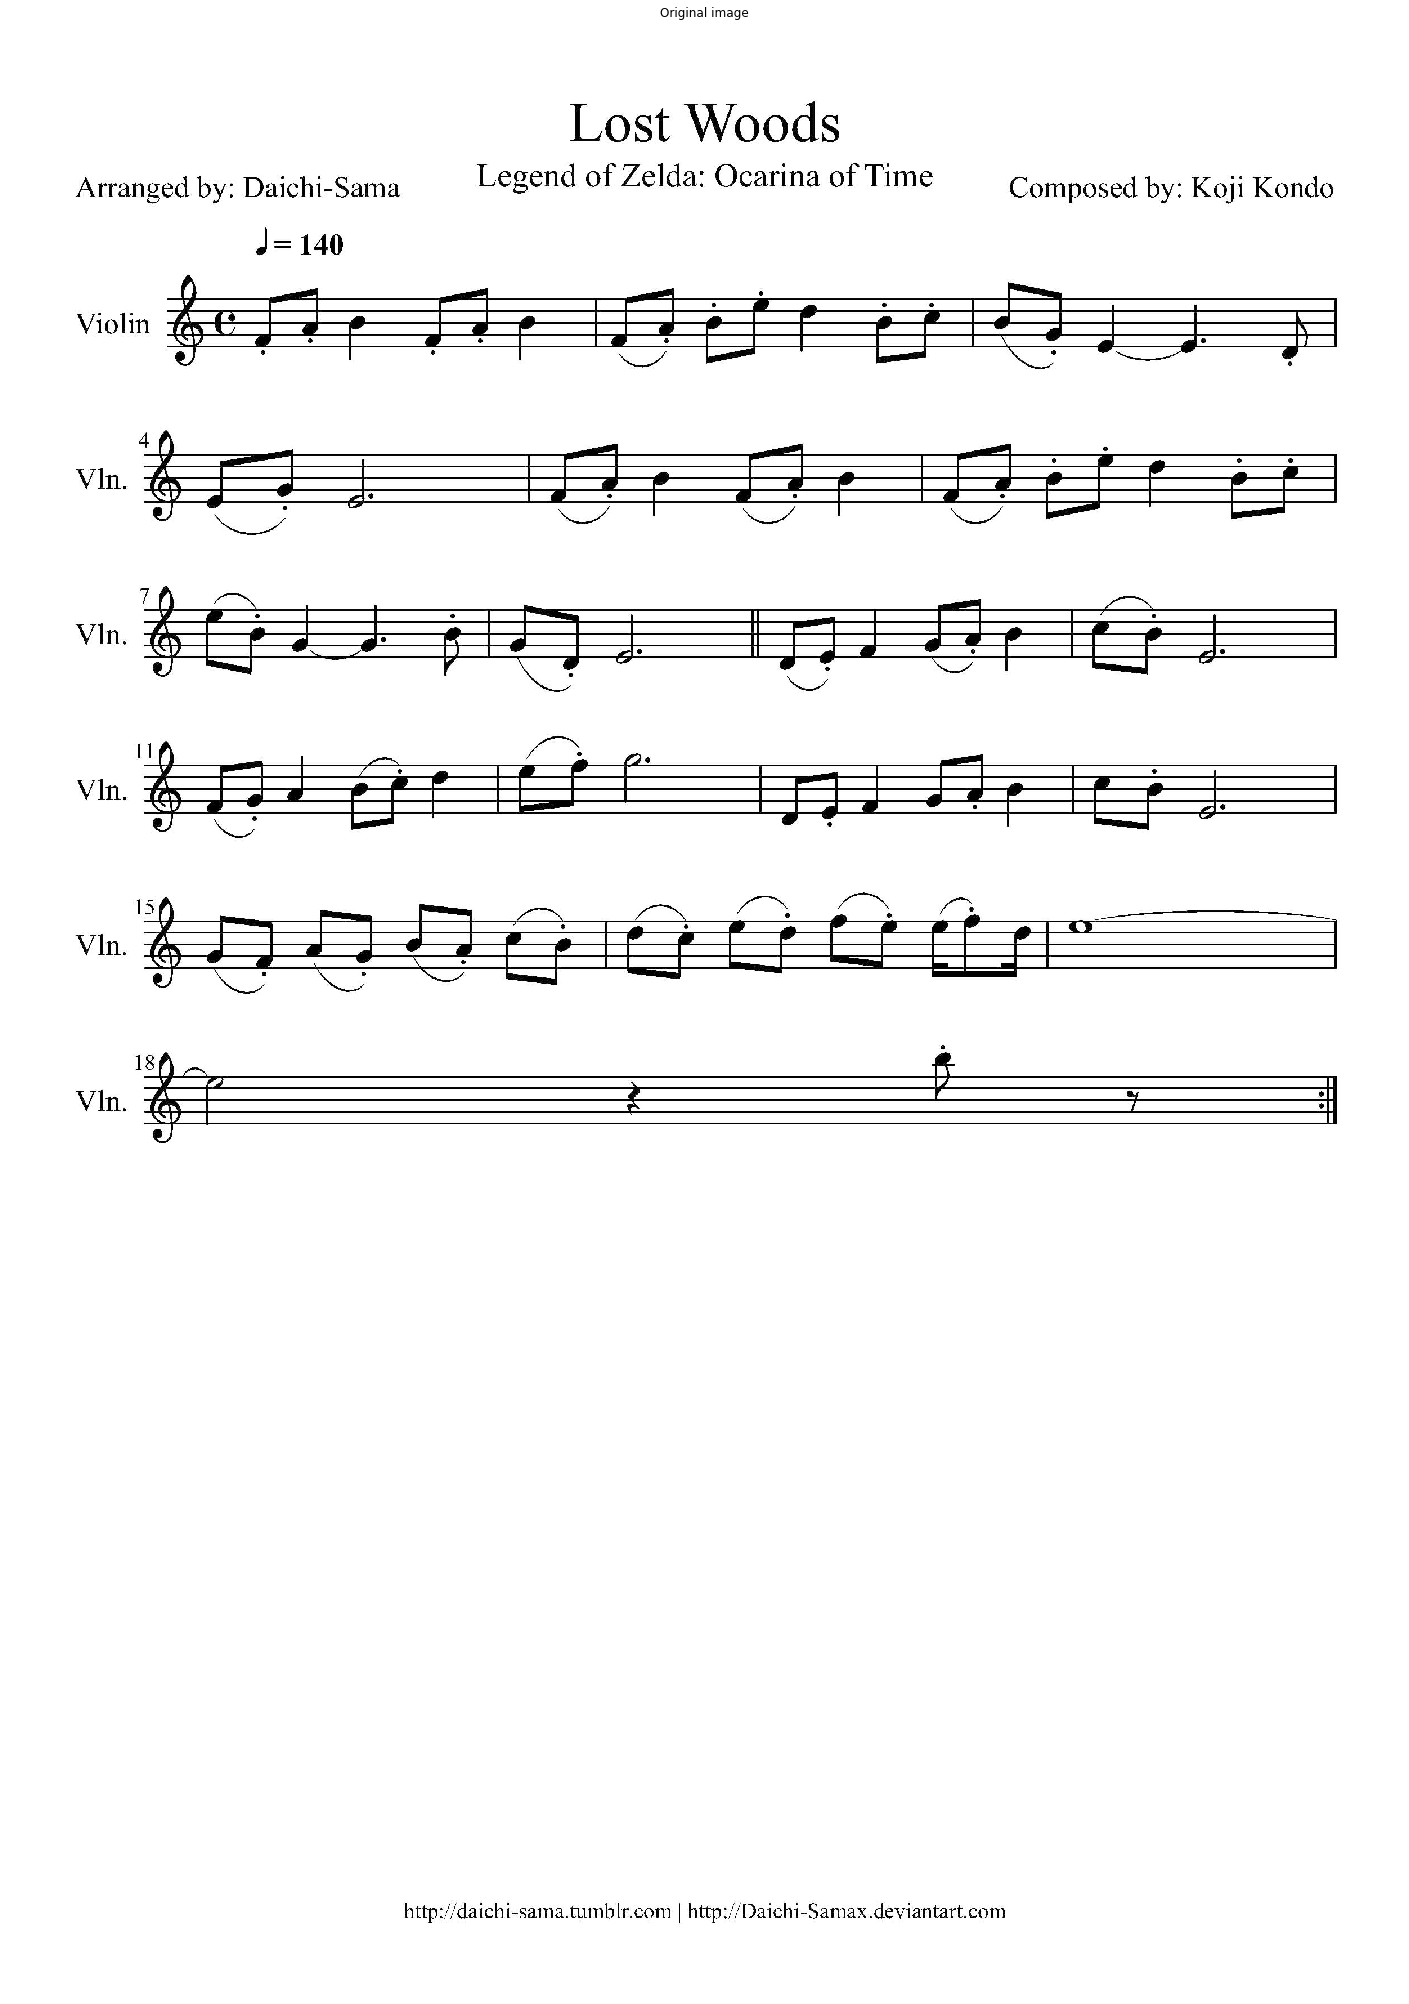

In [5]:
SELECTED_FILE = 2

gray_img = cv2.imread(os.path.join(DATA_PATH, sample_files[SELECTED_FILE]), 0)   
height, width = gray_img.shape
height, width

display_img(gray_img)
print((height, width))

Binarized image - 81.04ms


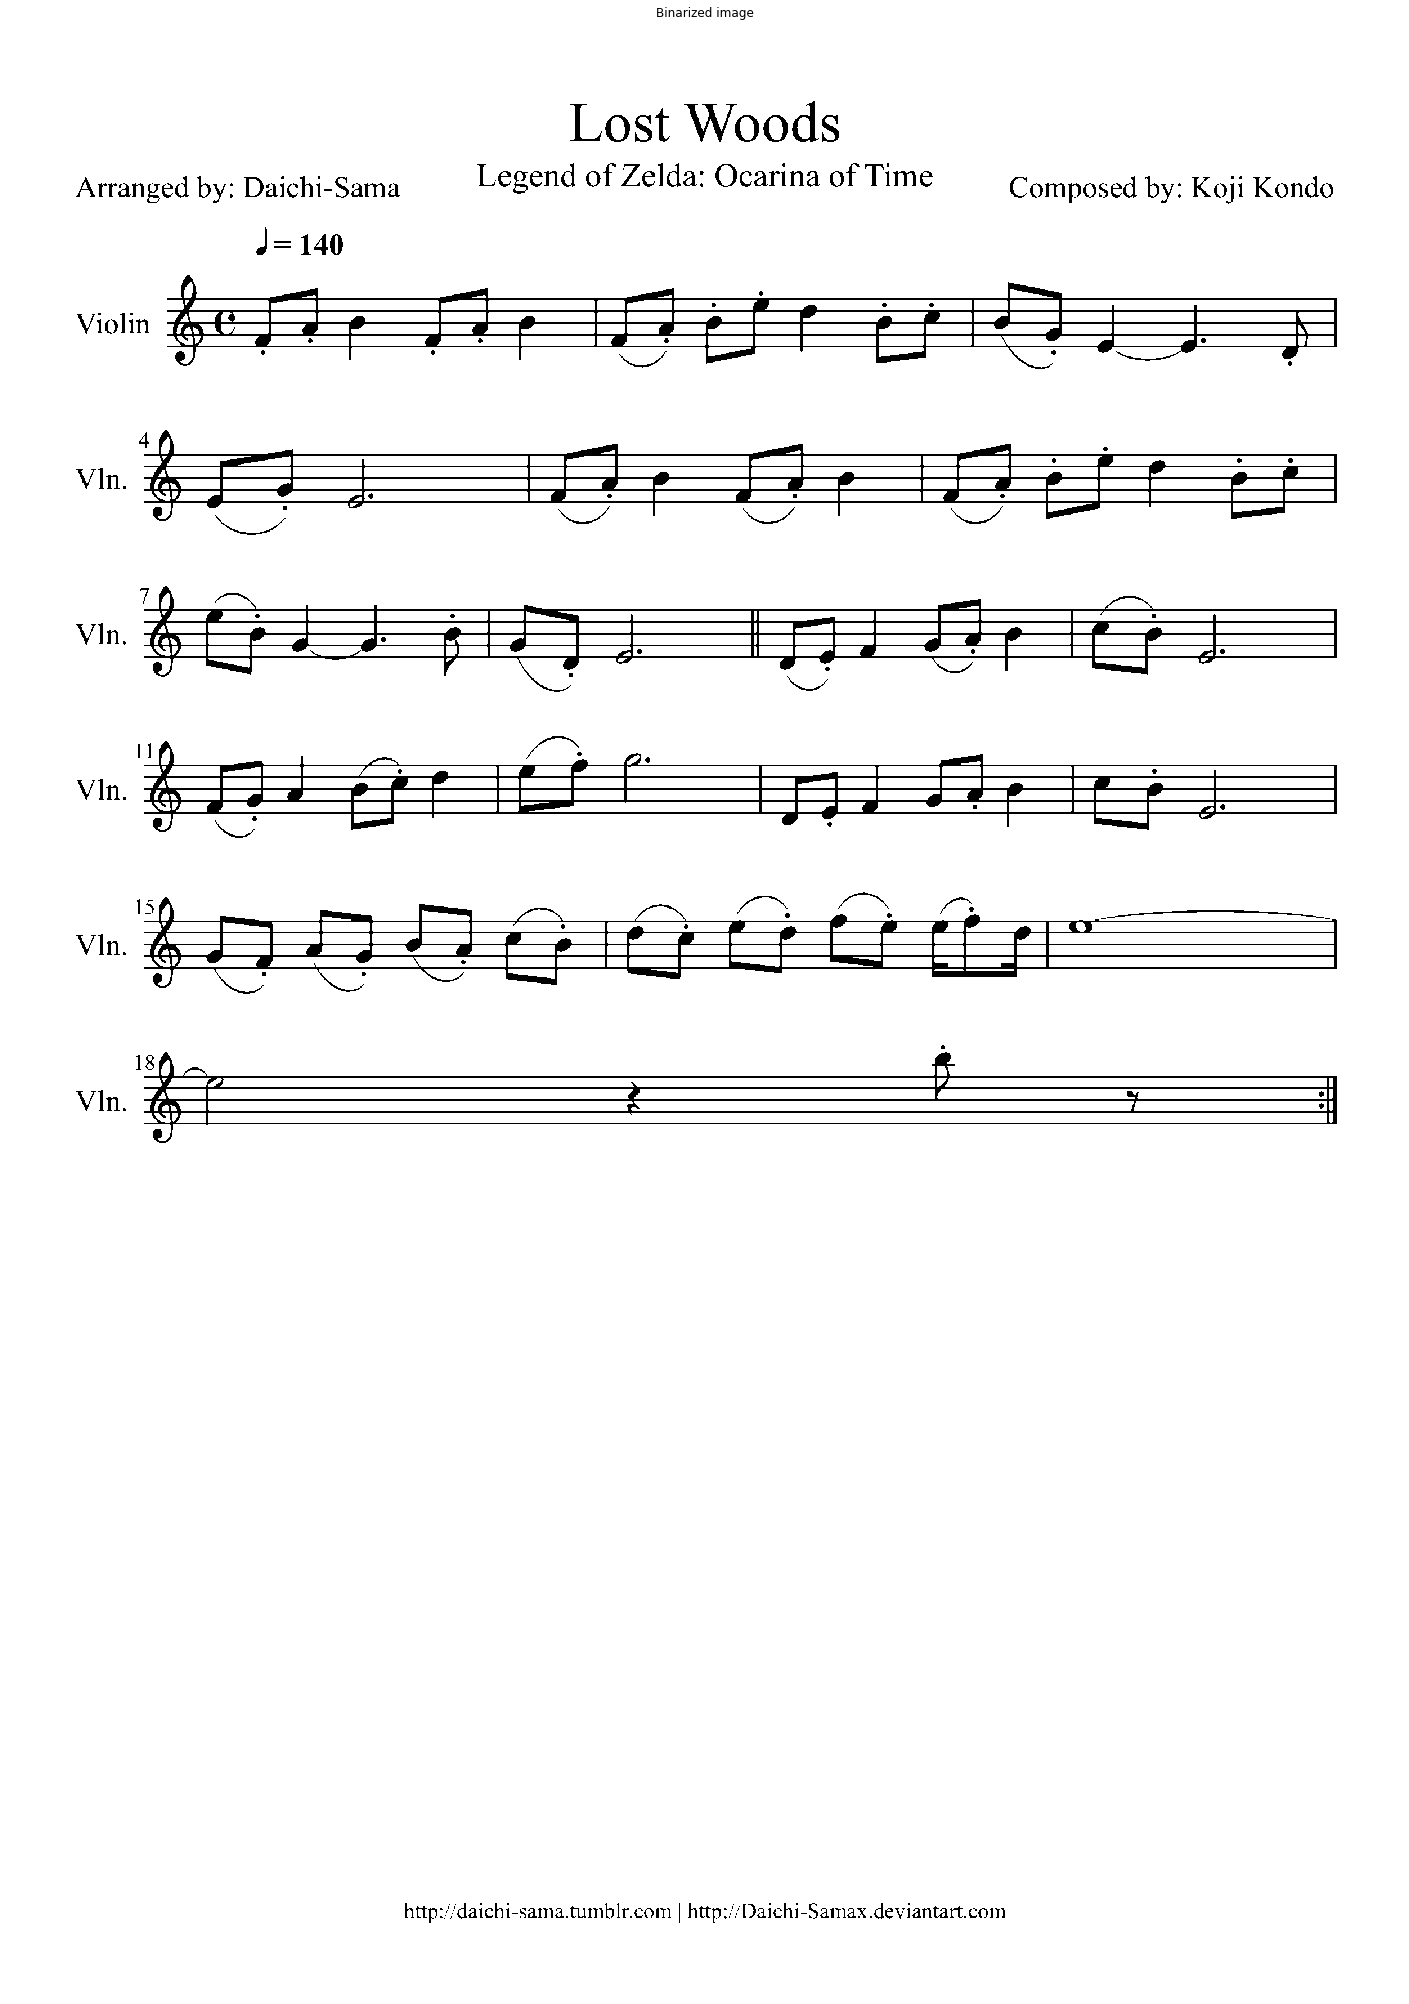

In [6]:
timer.start()
img = otsu_bin(gray_img)
timer.stop("Binarized image")

display_img(img, title="Binarized image")

## RLE encoding our image

Ok so now that we binarized our image, we should be left with pixels with value 0 or 1. Some calculations will be more efficient on a compressed image. A common technique is to use Run Length Compression (RLC) to do that. 

In [12]:
from utils.rle import rl_encode_2D, rl_decode_2D

timer.start()
rle, vals = rl_encode_2D(img)
timer.stop("Done with Run-Length encoding")

Done with Run-Length encoding - 654.33ms


In [13]:
# Quick check that rl_decoding works as well

encoded, vals = rl_encode_2D(img)
decoded = rl_decode_2D(encoded, vals, img.shape)
    
# display_img(decoded, title="Decoded RLE image")
assert (decoded - img == 0).all()

## Finding essential dimensions

Here we will sum consecutive pairs of RLE, then find most common value to evaluate line thickness and spacing.
This technique was validated by Pinto et al. in [1] as being the most commonly used.

[1] Pinto et al. - http://www.inescporto.pt/~jsc/publications/conferences/2011TPintoIbPRIA.pdf

In [14]:
from utils.rle_caracteristics import get_consecutive_sum, get_most_common_consec_sum, get_sum_components, get_characteristics

In [15]:
timer.start()
    
most_common = get_most_common_consec_sum(rle)

timer.stop(f"Computed consecutive sums and computed 'line_thickness+spacing={most_common}'")

Computed consecutive sums and computed 'line_thickness+spacing=21' - 38.79ms


In [16]:
# Let's try separating line thickness from spacing now.
# We have the entity as a sum, let's see the separate components of this sum.

timer.start()
line_thickness_mes, line_spacing_mes, _ = get_characteristics(rle, most_common)
timer.stop(f"Line thickness seems to be {line_thickness_mes}, while line spacing is {line_spacing_mes}.")

Line thickness seems to be 3, while line spacing is 18. - 108.22ms


## Down-scaling my image to a smaller one

For later work, like Hough ellipsis transform, it will be useful to work with a smaller image. I will therefore need to scale down my image, while still being able to see staff lines. I want staff lines to have a thickness of 2 when the image is scaled down. Knowing the thickness they have now, I will compute the ratio and resize my image accordingly.

In [17]:
MIN_THICKNESS = 2

In [18]:
if line_thickness_mes <= MIN_THICKNESS:
    resized_img = gray_img
    print("ERROR - image is small already, cannot rescale")
else:
    ratio = MIN_THICKNESS/line_thickness_mes
    dsize = (int(ratio*width), int(ratio*height))

    resized_img = cv2.resize(gray_img, dsize)
    
# display_img(resized_img, title=f"Resized image with ratio {ratio}")

# CHOOSE WHICH IMAGE TO WORK WITH

Resized or original ?

Line thickness seems to be 3, while line spacing is 18. - 718.10ms


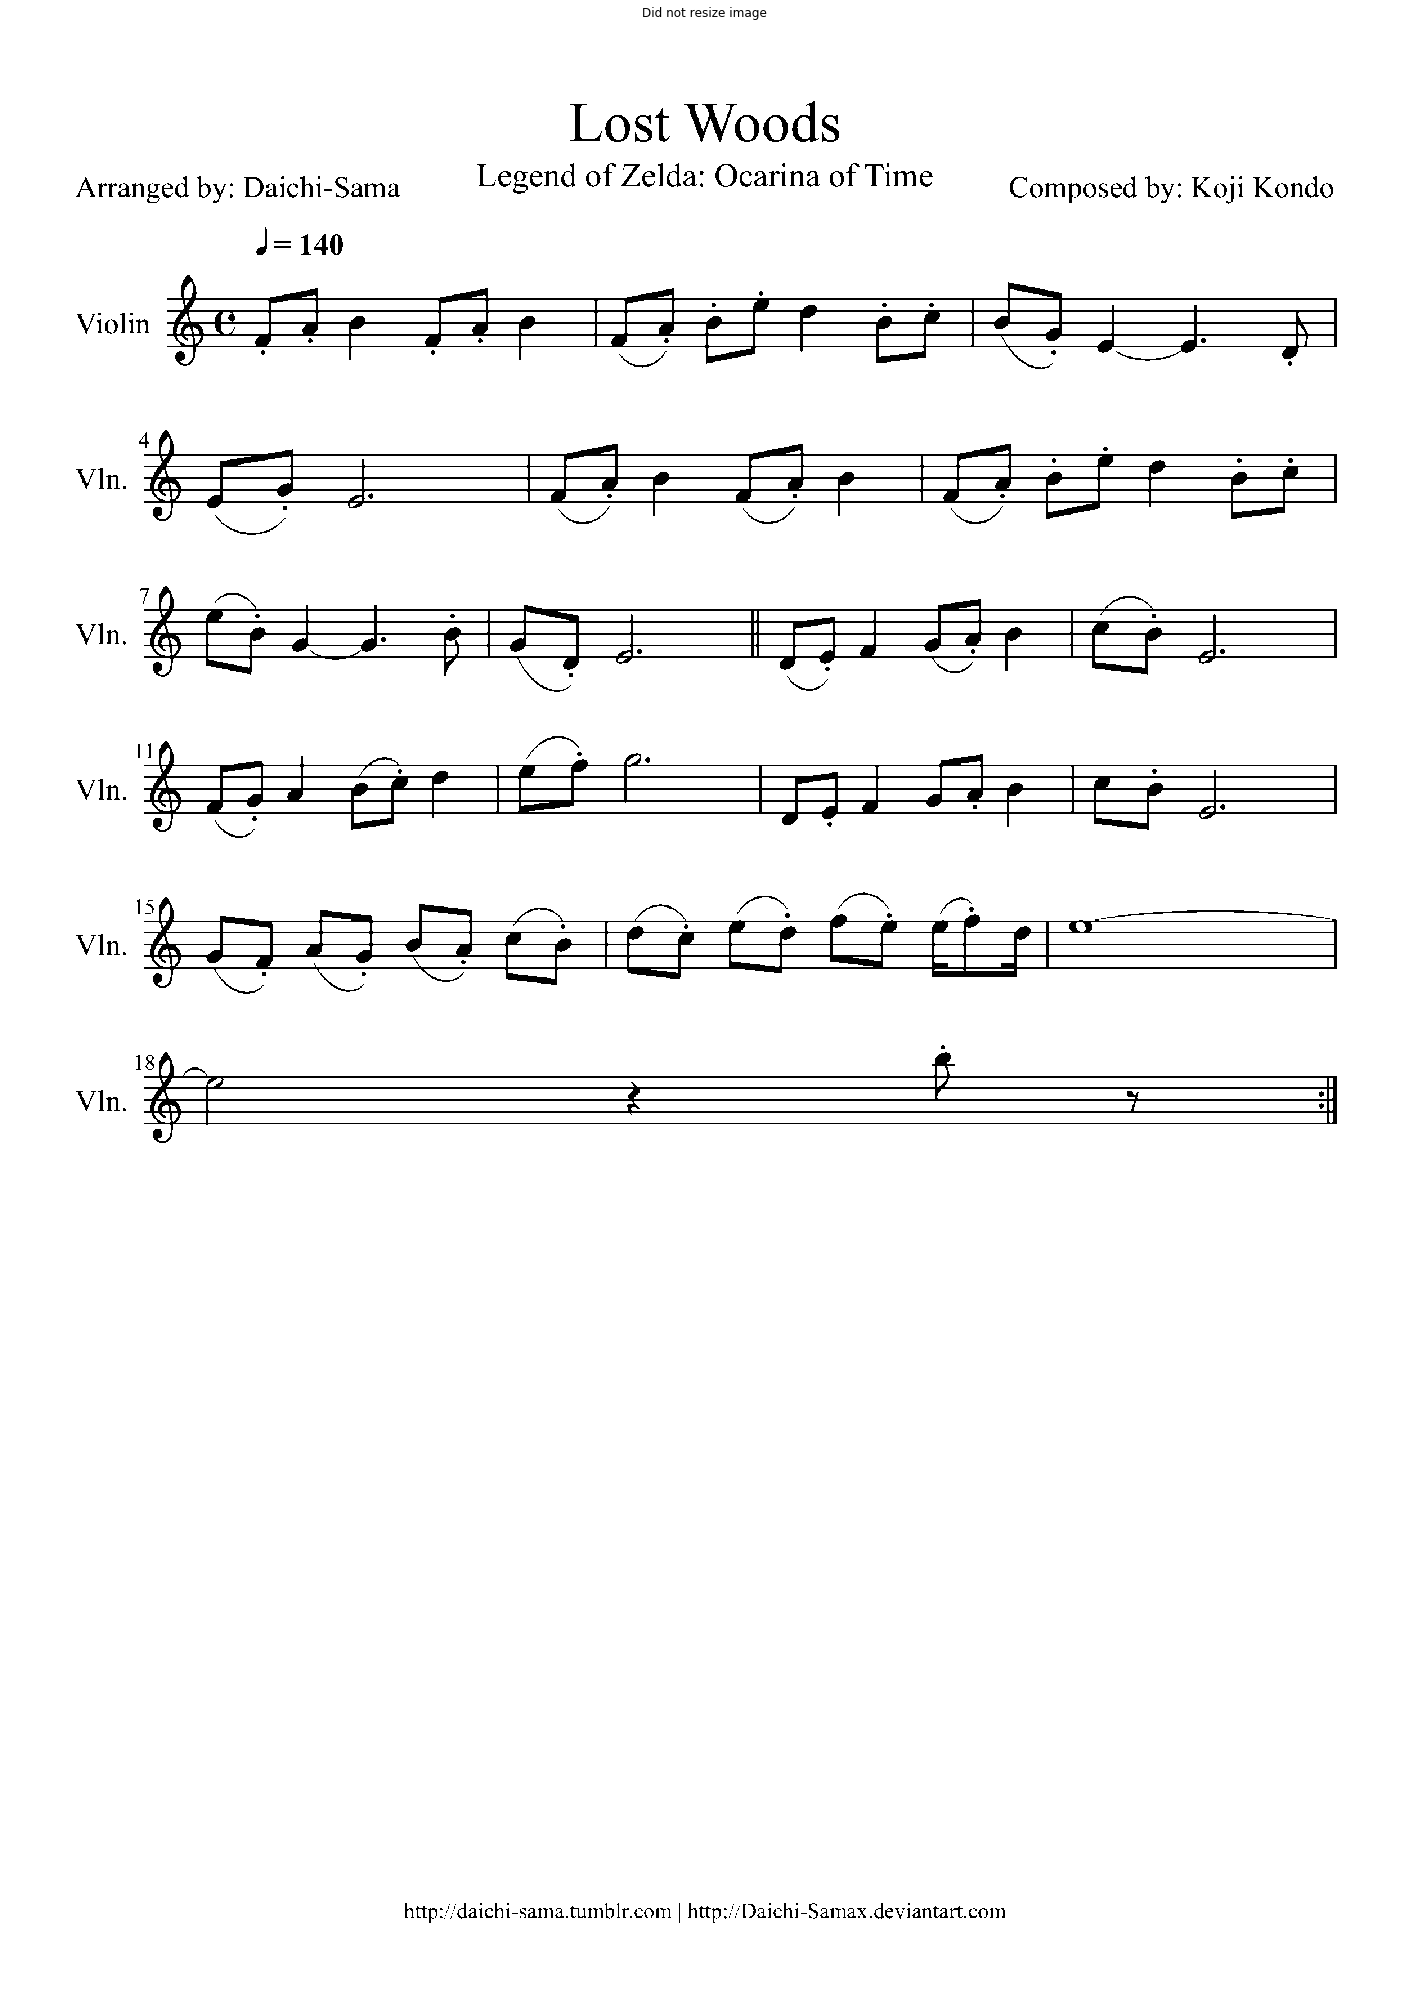

In [19]:
resized = False

timer.start() 
if resized:
    work_img = resized_img
    width = int(width*ratio)
    height = int(height*ratio)
else:
    work_img = gray_img
    line_thickness = line_thickness_mes
    line_spacing = line_spacing_mes
    
img = otsu_bin(work_img)
rle = rl_encode_2D(img)

if resized:
    most_common = get_most_common_consec_sum(rle)
    line_thickness, line_spacing, counter = get_characteristics(rle, most_common)
    
timer.stop(f"Line thickness seems to be {line_thickness}, while line spacing is {line_spacing}.")
title = f"Resized image with ratio {ratio}, then binarized it" if resized else "Did not resize image" 
display_img(img, title=title)

## Removing staff lines

To remove staff lines, we will try removing any vertical RLE block that is bigger than twice the computed line height.

This method to detect lines can be approximative, but we will start with that for now. We will test Line detection using Hough transform as well, and might try and combine both these methods to refine the removal of the staff lines.

In [23]:
filtered_rle, vals = [remove_black_blocks(arr, vals, 2*line_thickness) for arr in rle]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [21]:
no_staff_line_image = rl_decode_2D(filtered_rle, vals, work_img.shape)

display_img(no_staff_line_image, title="Removed staff lines from image")

NameError: name 'filtered_rle' is not defined

## Removing vertical straight lines

Knowing how to do that will definitely be useful in the future

In [899]:
# Horizontal RL encoding
h_rle = rl_encode_2D(no_staff_line_image, axis=0)

# Finding average size of vertical lines

In [900]:
filtered_h_rle = [remove_black_blocks(arr, 2*line_thickness) for arr in h_rle]

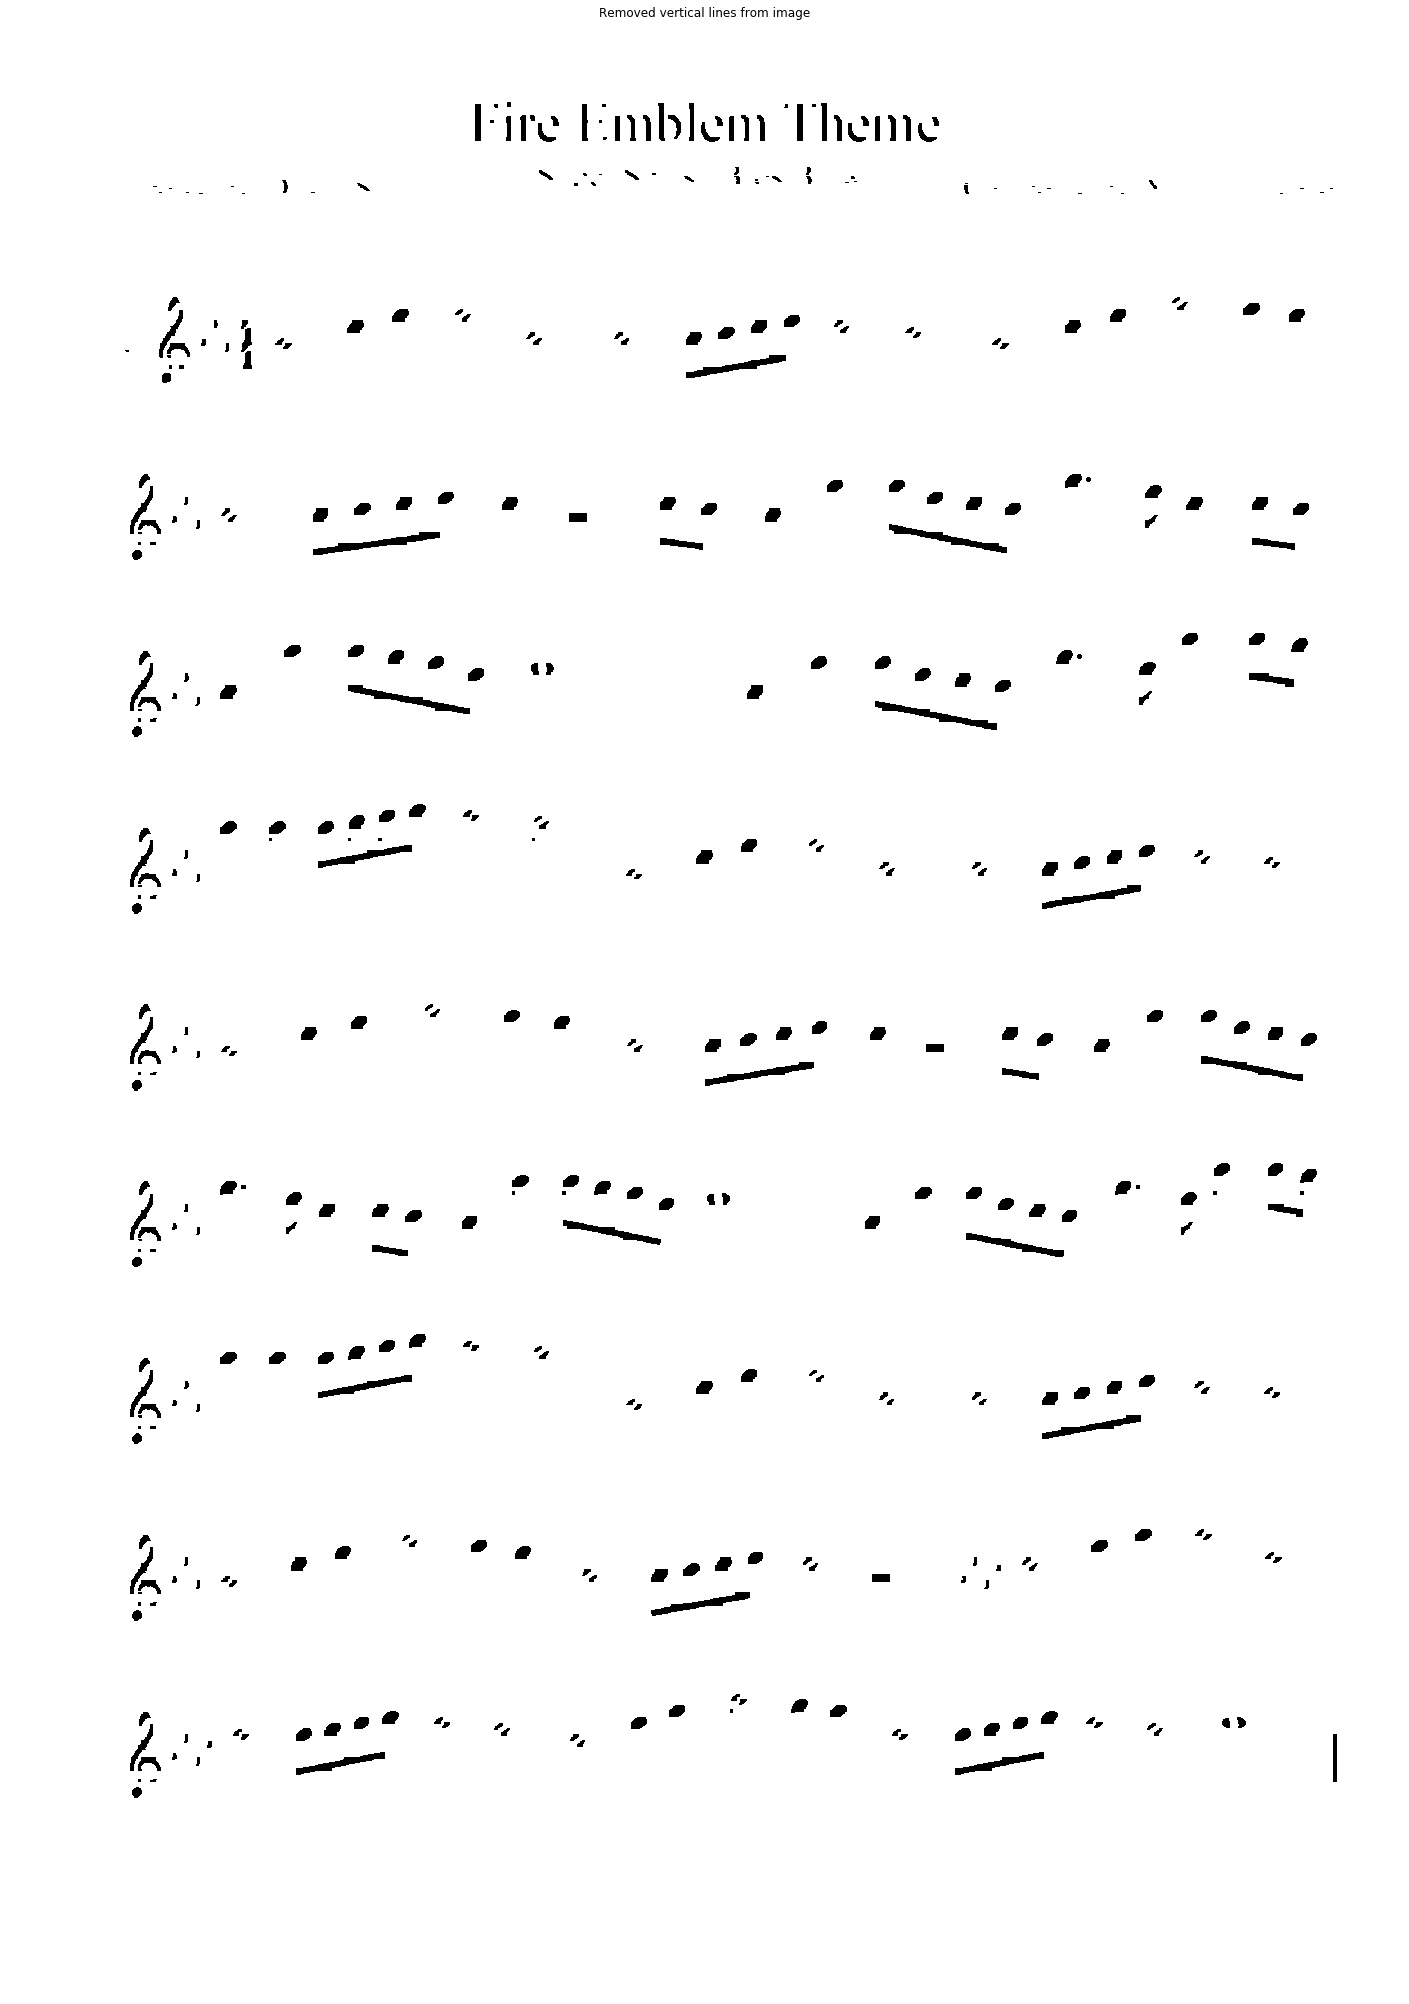

In [901]:
no_v_line_image = rl_decode_2D(filtered_h_rle, img.shape, axis=0)
display_img(no_v_line_image, title="Removed vertical lines from image")

## Edge detection

To detect edges in our image, we can obviously use a Canny filter. 

However, to detect horizontal lines, applying a derivative along the y axis mignt work as well, using a Sobel filter. We will test both methods out.

> NB. For now we apply edge detection to grayscale image, not to otsu binarized image.

In [902]:
# Canny filter method
timer.start()
canny_prep_image = 255 - 255*(abs(img - no_staff_line_image)).astype(np.uint8)

edges = cv2.Canny(canny_prep_image,100,200)

timer.stop("Executed Canny filter")
#display_img(edges, title="Canny filter applied to image")

Executed Canny filter - 46.65ms


In [903]:
# Sobel method
timer.start()

threshold=0.7

sobely = cv2.Sobel(canny_prep_image,cv2.CV_64F,0,1,ksize=5)
sobely = np.abs(sobely) / (max((np.max(sobely), np.abs(np.min(sobely)))))
_,thresholded_sobely = cv2.threshold(sobely,threshold,255,cv2.THRESH_BINARY)

thresholded_sobely = thresholded_sobely.astype('uint8')

timer.stop("Executed Sobel filtering")
#display_img(thresholded_sobely, title="Sobel Y filter applied with threshold")

Executed Sobel filtering - 149.58ms


Done calculating Hough Line detection - 89.79ms
Finished selecting lines - 97.21ms


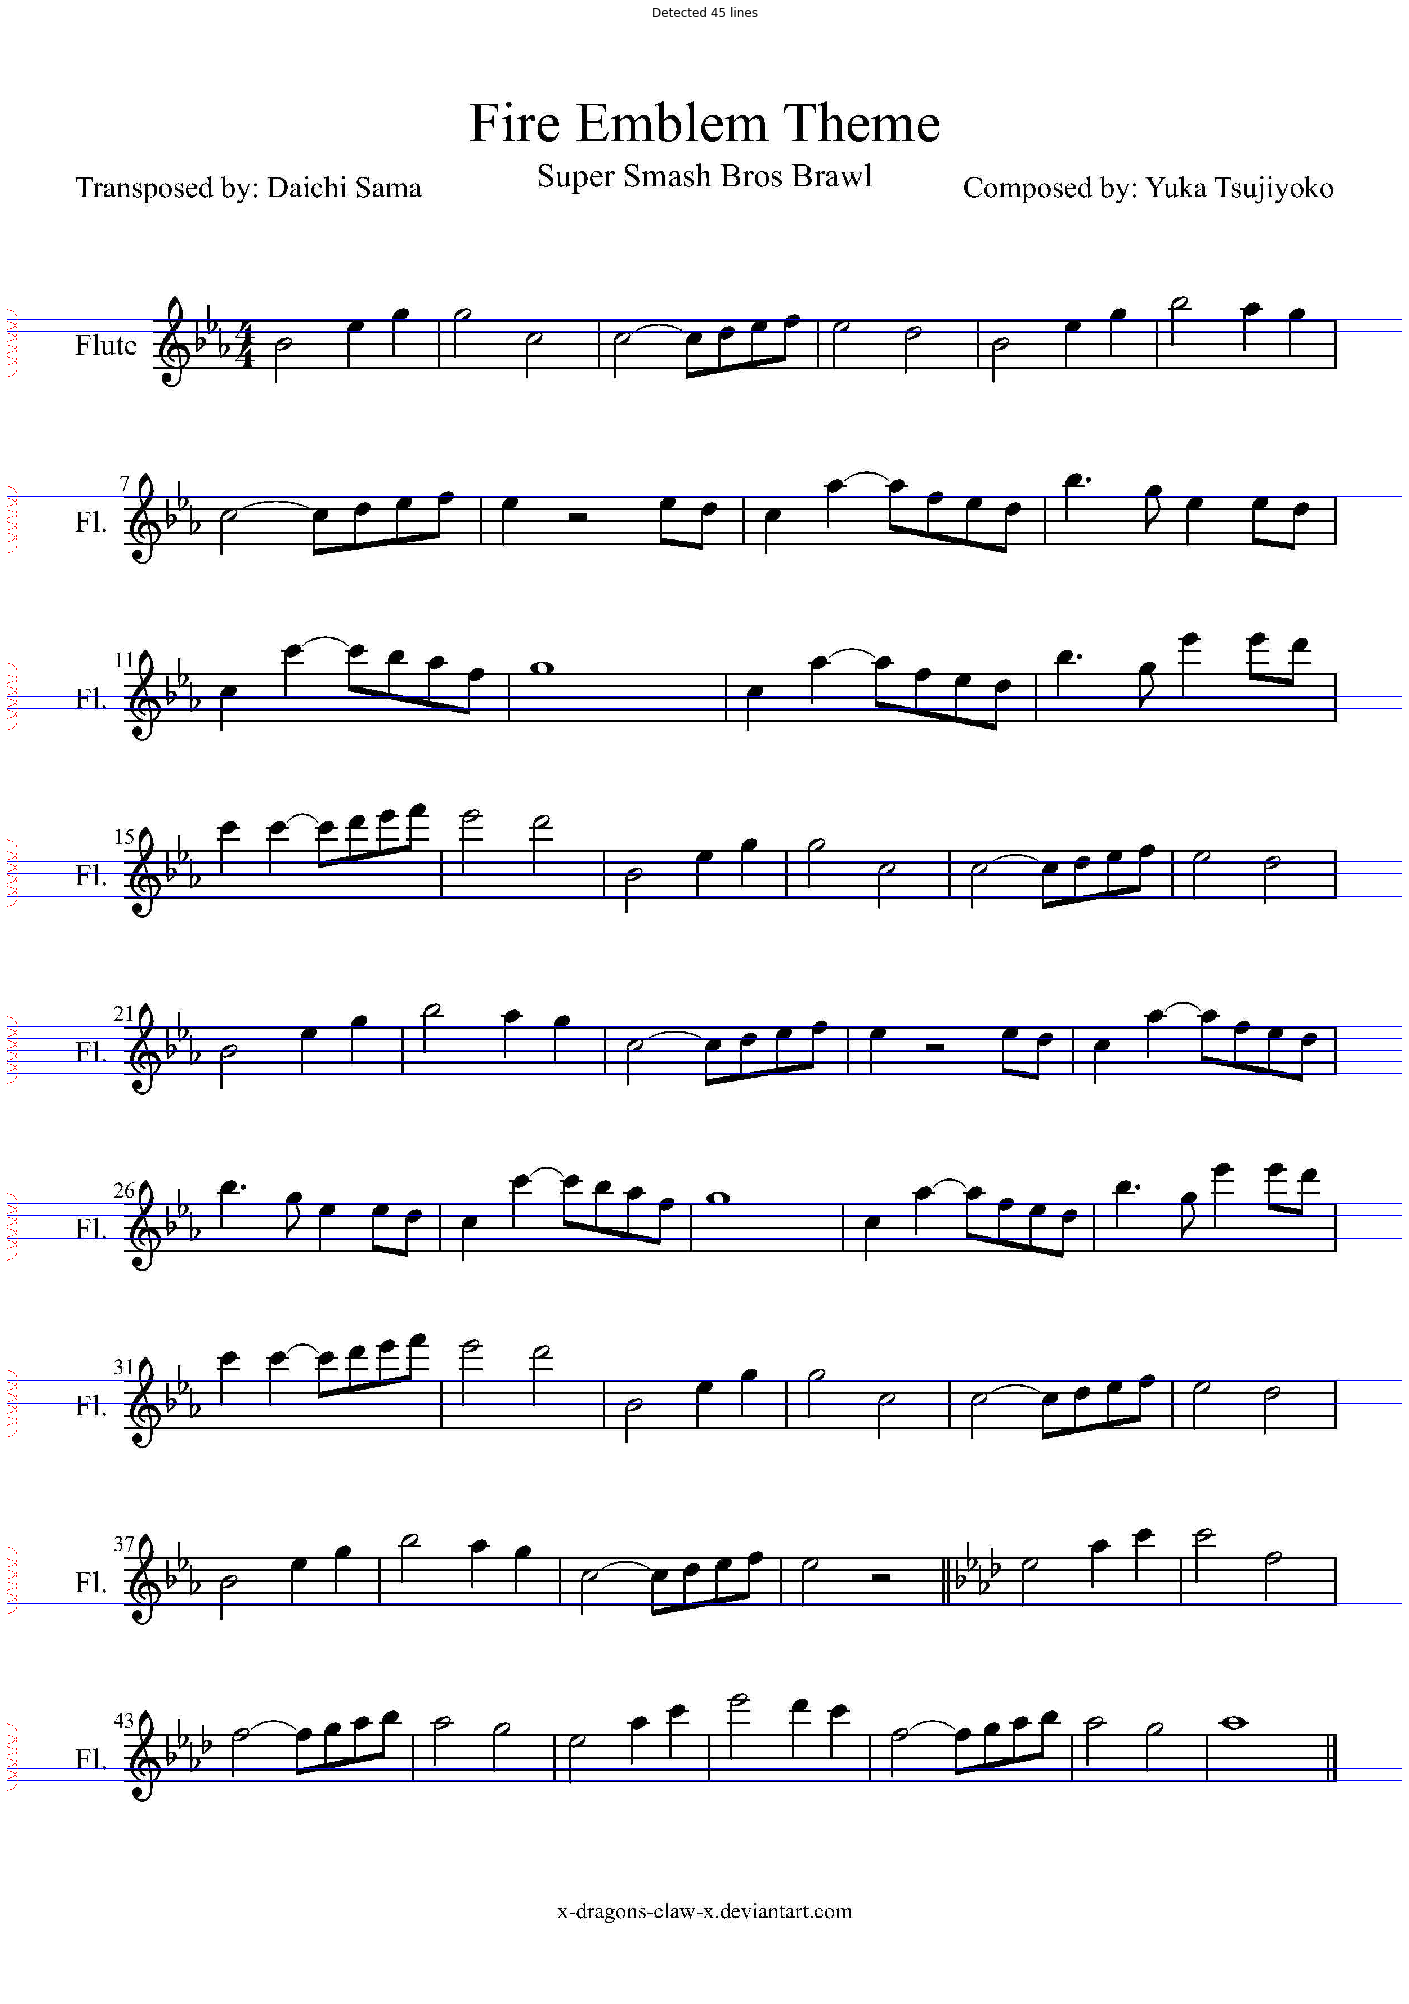

In [904]:
color_img = cv2.cvtColor(work_img, cv2.COLOR_GRAY2RGB)

timer.start()
lines = [(line[0][0], line[0][1]) for line in cv2.HoughLines(edges,1,np.pi/180,int(width/2),500)]
timer.lap("Done calculating Hough Line detection")
cartesian_lines = []

for rho,theta in lines:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    x1 = int(x0 + width*b)
    y0 = b*rho
    cartesian_lines.append((y0, x0, x1))
    
filtered_lines = []
cartesian_lines = sorted(cartesian_lines, key=lambda l: l[0])

for index, line in enumerate(cartesian_lines):
    if index>0  and (line[0] - filtered_lines[-1][0] < 0.9*line_spacing):
        pass
    else:
        y0, x0, x1 = line
        filtered_lines.append(line)
        cv2.line(color_img,(x0,y0),(x1,y0),(0,0,255),1)
        cv2.circle(color_img, (x0, y0), line_spacing, (255,0,0), 1)

timer.stop("Finished selecting lines")

display_img(color_img, title=f"Detected {len(filtered_lines)} lines")

## Defining interest zones

We will now define interest zones. We would like to trace a rectangle around this interest zone.

At first, these rectangle will be as wide as the music sheet is.

To define top and bottom boundaries, of each zone, we look at the lines detected by Hough Transform line detection, and keep only the top and bottom line of each group. We do this using the fact that they are in groups of 5 lines, and that the distance between the top and bottom line is bigger than 4 times line spacing (because of line thickness). We can then evaluate distance between two groups, find the center of a line grouping, and trace rectangles with sufficient padding. 

It is important to note that no arbitrary values have been used here. Finding these groups is only based on characteristics of the image.

In [905]:
color_img = cv2.cvtColor(work_img, cv2.COLOR_GRAY2RGB)

top_bottom_lines = []
for index, line in enumerate(filtered_lines):
    if index>0  and (line[0] - top_bottom_lines[-1][0] <= 4*line_spacing):
        pass
    else:
        y0, x0, x1 = line
        top_bottom_lines.append(line)
        
consec_dists = []
for i in range(len(top_bottom_lines)-1):
    consec_dists.append( top_bottom_lines[i+1][0] - top_bottom_lines[i][0] )
        
big_spacing = max(consec_dists)
box_margin = int(big_spacing/2)

centers = []
for i in range(0, len(top_bottom_lines)-1, 2):
    center_position = int((top_bottom_lines[i+1][0]-top_bottom_lines[i][0])/2)
    center_y = top_bottom_lines[i][0] + center_position
    centers.append((center_y, center_position))

display_margin = int(big_spacing/10)
interest_zones = []
for (center, offset) in centers:
    top = int(center) - box_margin - offset + display_margin
    bottom = int(center) + box_margin + offset - display_margin
    interest_zones.append((top, bottom, 0, width))
    cv2.rectangle(color_img, (0, top), (width, bottom), (255,0,0), 2)

display_img(color_img, title=f"Detected {len(centers)} interest zones")

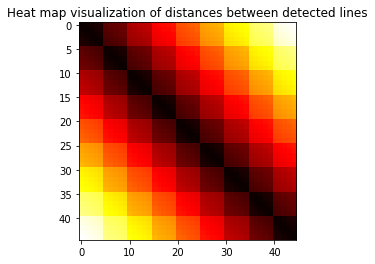

In [906]:
# sort by y coordinate of line
distance_matrix = np.array([[abs(l2[0] - l1[0]) for l2 in filtered_lines] for l1 in filtered_lines])

plt.imshow(distance_matrix, cmap='hot', interpolation='nearest')
plt.title("Heat map visualization of distances between detected lines")
plt.show()

# Testing with HoughLinesP now

In [907]:
color_img = cv2.cvtColor(work_img, cv2.COLOR_GRAY2RGB)

timer.start()
minLineLength = width/2
maxLineGap = 50
lines = [line[0] for line in cv2.HoughLinesP(edges,1,np.pi/180,100,minLineLength=minLineLength,maxLineGap=maxLineGap)]
timer.lap("Done calculating Hough Line detection")

for x1,y1,x2,y2 in lines:
    cv2.line(color_img,(x1,y1),(x2,y2),(0,255,0),2)
    
timer.stop("Finished selecting lines")

# display_img(color_img, title=f"Detected {len(lines)} lines")

Done calculating Hough Line detection - 96.51ms
Finished selecting lines - 98.19ms


## Detecting symbols on the music sheet

### First try - Ellipsis detection using Hough transform

We will here use an approach based on ellipsis detection to detect the shapes of notes on our image. We will evaluate the performance of such method on different versions of the image (gray_scale, binarized, binarized without staff lines).

Hough ellipsis detection is implemented in scikit-image as per [1].

[1] https://scikit-image.org/docs/dev/auto_examples/edges/plot_circular_elliptical_hough_transform.html#references


In [28]:
from skimage.transform import hough_ellipse

In [29]:
# Canny filter method
timer.start()

no_staff_edges = cv2.Canny(
    (no_staff_line_image*255).astype(np.uint8),
    100,
    200
)

timer.stop("Executed Canny filter")
display_img(no_staff_edges[interest_zones[0][0]:interest_zones[0][1], 270:650], title="Canny filter applied to image without staff lines")
no_staff_edges.shape

Executed Canny filter - 37.61ms


(3508, 2479)

In [30]:
no_staff_edges[interest_zones[0][0]:interest_zones[0][1], 270:650].shape

(238, 380)

In [31]:
no_staff_edges.shape

(3508, 2479)

In [69]:
timer.start()
result = hough_ellipse(
    no_staff_edges[interest_zones[0][0]:interest_zones[0][1], 170:410]/255,
    min_size=int(line_spacing/2), 
    max_size=2*line_spacing,
)
timer.stop("Performed Hough ellipsis transform")
result

Performed Hough ellipsis transform - 3.80ms


array([], shape=(0, 6), dtype=float64)

In [70]:
print(len(result))
result.sort(order='accumulator')
res = list(map(list,  result))
res[-10:-1]

0


ValueError: Cannot specify order when the array has no fields.

In [71]:
color_img = cv2.cvtColor(work_img, cv2.COLOR_GRAY2RGB)
im_to_draw = color_img[interest_zones[0][0]:interest_zones[0][1], 170:410]

for ellipsis in res[-40:-1]:
    yc, xc, a, b = [int(round(x)) for x in ellipsis[1:5]]
    orientation = ellipsis[5]
    cv2.ellipse(im_to_draw, (xc, yc), (b, a), int(orientation), 0, 360, (255,0,0), 1)
    
display_img(im_to_draw)

NameError: name 'res' is not defined

## Second try - Clustering pixels into notes

Hough ellipsis detection does not seem to be very time efficient. We will now try a different approach, by considering notes (especially quarters, eigths...) as clusters of black pixels. Let's see how a clustering approach works for note detection !

### Getting the coordinates

We tried out a few methods already, but most of them were quite slow. Let's try and find an approach which is time efficient !

In [32]:
import pandas as pd

def filter_in_zone(arr, interest_zones):
    x_list = arr[:, 0]
    result = None
    for top, bottom, _, _ in interest_zones:
        if result is not None:
            a = x_list[x_list>=top]
            result = np.append(result, a[a<=bottom])
        else:
            a = x_list[x_list>=top]
            result = a[a<=bottom]
    indices = [i for i in range(len(x_list)) if x_list[i] in result]
    return np.take(arr, indices)

def pandas_method(arr, interest_zones):
    df = pd.DataFrame(arr)
    result = None
    for top, bottom, _, _ in interest_zones:
        if result is None:
            result = df[(df[0] <= bottom) & (df[0] >= top)]
        else:
            result.append(df[(df[0] <= bottom) & (df[0]) >= top])

    return result.to_numpy(dtype=np.int32)

In [33]:
# Let's test some methods to get coordinates of black pixels in our interest zones.

timer.start()
Y = np.argwhere(no_staff_line_image == 0)
timer.lap("converted to coordinates")
# A = list(filter(lambda pair: is_in_any_zone(pair, interest_zones), Y)) 
timer.lap("Filtered pixels in zone & convert to list with filter") # 53816.41ms
# B = filter_in_zone(Y, interest_zones)
timer.lap("Filtered pixels in zone & using a couple numpy functions") # wayyyy too long
C = pandas_method(Y, interest_zones)
timer.stop("Filtered pixels in zones using pandas dataframe row filtering") # 886.10ms


# We will obviously use the last method !

converted to coordinates - 31.91ms
Filtered pixels in zone & convert to list with filter - 0.13ms
Filtered pixels in zone & using a couple numpy functions - 0.05ms
Filtered pixels in zones using pandas dataframe row filtering - 56.21ms


In [744]:
def is_in_zone(pixel, interest_zone):
    top, bottom, left, right = interest_zone
    x, y = pixel
    return x >= top and x <= bottom and y >= left and y <= right

def is_in_any_zone(pixel, interest_zones):
    return any(map(lambda x: is_in_zone(pixel, x), interest_zones))

def get_black_pixels_in_interest_zones(image, int_zones):
    arr = np.argwhere(image == 0)
    df = pd.DataFrame(arr)
    result = None
    for top, bottom, left, right in int_zones:
        if result is None:
            result = df[(df[0] <= bottom) & (df[0] >= top) & (df[1] >= left) & (df[0] <= right)]
        else:
            result = result.append(df[(df[0] <= bottom) & (df[0] >= top) & (df[1] >= left) & (df[0] <= right)])

    return result.to_numpy(dtype=np.int32)


In [580]:
timer.start()

# Get coordinates of black pixels in interest zones
X = get_black_pixels_in_interest_zones(no_v_line_image, interest_zones) 

timer.stop("Converted binary image to coordinates of black pixels using most efficient method") # 56.08ms

Converted binary image to coordinates of black pixels using most efficient method - 56.26ms


In [581]:
timer.start()
a, b = no_v_line_image.shape

# Get coordinates of black pixels in interest zones
etalon = np.array([
    [i, j] for i in range(a) for j in range(b) if (no_v_line_image[i, j] == 0 and is_in_any_zone((i, j), interest_zones))
]) 
timer.stop("Converted binary image to coordinates of black pixels using old method") # 14276.21ms

Converted binary image to coordinates of black pixels using old method - 14721.45ms


In [582]:
assert (X == etalon).all()

### Clustering

Did find a pretty efficient method, we will use it from now on!

In [908]:
X = get_black_pixels_in_interest_zones(no_v_line_image, interest_zones) 

In [909]:
from sklearn.cluster import DBSCAN

timer.start()
db = DBSCAN(eps=1.5*line_thickness, min_samples=10).fit(X)

labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

timer.stop('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 265 - 2202.66ms
Estimated number of noise points: 0


In [910]:
color_img = cv2.cvtColor(work_img, cv2.COLOR_GRAY2RGB)

colors = np.array([plt.cm.Spectral(each)
          for each in np.linspace(0, 1, n_clusters_)])[:, :-1]*255
np.random.shuffle(colors)

for index, label in enumerate(labels):
    color_img[X[index][0], X[index][1]] = colors[label]
    
# display_img(color_img, title="Applying DBSCAN to the image after staff line removal")

In [911]:
color_img = cv2.cvtColor(work_img, cv2.COLOR_GRAY2RGB)
colors = np.array([plt.cm.Spectral(each)
          for each in np.linspace(0, 1, n_clusters_)])[:, :-1]*255
np.random.shuffle(colors)

pixels_by_cluster = [[] for i in range(n_clusters_)]
for index, label in enumerate(labels):
    if pixels_by_cluster[label]:
        pixels_by_cluster[label].append(X[index])
    else:
        pixels_by_cluster[label] = [X[index]]
        
cluster_boundaries = []
for cluster in pixels_by_cluster:
    cluster = np.array(cluster)
    
    top = min(cluster[:, 0])
    bottom = max(cluster[:, 0])
    left = min(cluster[:, 1])
    right = max(cluster[:, 1])
    
    cluster_boundaries.append(((top, bottom, left, right), cluster))
    
padding = 2*line_thickness
for index, ((top, bottom, left, right), pixels) in enumerate(cluster_boundaries):
    color = colors[len(colors)-index-1]
    cv2.rectangle(color_img, (left-padding, top-padding), (right+padding, bottom+padding), color, 2)
    
for top, bottom, left, right in interest_zones:
    cv2.rectangle(color_img, (left, top), (right, bottom), (255,0,0), 2)

display_img(color_img, title="Applying DBSCAN to the image after staff and vertical line removal")    

In [853]:
def rect_intersect(the_one, the_other, tolerance=0):
    top, bottom, left, right = the_one
    t, b, l, r = the_other
    
    return not (right+tolerance < l or left-tolerance > r or top-tolerance > b or bottom+tolerance < t)

def rect_intersect_any(the_one, the_others, tolerance=line_thickness):
    for other in the_others:
        if the_one != other and rect_intersect(the_one, other, tolerance=tolerance):
            return True
    return False

### Filter important clusters

we will now filter out clusters whose aspect ratio is not the one of a note, and regroup the remaining ones that overlap.

In [854]:
color_img = cv2.cvtColor(work_img, cv2.COLOR_GRAY2RGB)
colors = np.array([plt.cm.Spectral(each)
          for each in np.linspace(0, 1, n_clusters_)])[:, :-1]*255
np.random.shuffle(colors)
    
# Filter note-sized clusters
vertical_min_size = line_spacing*0.5
horizontal_min_size = line_spacing*0.5
note_filtered = [(cluster, pixels) for (cluster, pixels) in cluster_boundaries if cluster[1]-cluster[0] >= vertical_min_size and cluster[3]-cluster[2] >= horizontal_min_size]
  
# Now let's regroup clusters that have areas in common
grouped_clusters = []
grouping_clusters = [[x, False] for x in note_filtered]

i = 0
while i < len(grouping_clusters):
    cluster, gr = grouping_clusters[i]
    (top, bottom, left, right), pixels = cluster

    for j, (cl, g) in enumerate(grouping_clusters):
        (t, b, l, r), px = cl
                                 
        if cl == cluster:
            pass
        else:
            if rect_intersect((top, bottom, left, right), (t, b, l, r), tolerance=line_spacing-line_thickness) and not g:
                gr = True
                grouping_clusters[i][1] = True
                grouping_clusters[j][1] = True
                grouped_clusters.append(((
                    min(top, t), 
                    max(bottom, b), 
                    min(left, l), 
                    max(right, r)
                ), np.vstack((pixels,px))))
    if not gr:
        grouped_clusters.append(((top, bottom, left, right), pixels))
    i+=1
    
# Filter note-sized clusters, AGAIN
vertical_max_size = line_spacing + 2*line_thickness
horizontal_max_size = 2*line_spacing + 2*line_thickness
note_filtered = [(cluster, px) for (cluster, px) in grouped_clusters if cluster[1]-cluster[0] <= vertical_max_size and cluster[3]-cluster[2] <= horizontal_max_size]
    
vertical_min_size = line_spacing*0.7
horizontal_min_size = line_spacing*0.5
note_filtered = [(cluster, px) for (cluster, px) in note_filtered if cluster[1]-cluster[0] >= vertical_min_size and cluster[3]-cluster[2] >= horizontal_min_size]
   
# Filter for orientation to be horizontal
note_filtered = [
    ((t,b,l,r), px) for ((t,b,l,r), px) in note_filtered if r-l>b-t
]

padding = 2*line_thickness
for index, ((top, bottom, left, right), px) in enumerate(note_filtered):
    color = colors[index]
    cv2.rectangle(color_img, (left-padding, top-padding), (right+padding, bottom+padding), color, 2)
    
for top, bottom, left, right in interest_zones:
    cv2.rectangle(color_img, (left, top), (right, bottom), (255,0,0), 2)
    
display_img(color_img, title="Grouped clusters whose bounding boxes intersect")    

## Evaluating note height

Super cool, so now we managed trace boxes around all of our notes ! This is so cool ! Now, we want to get the note height from these boxes. But as you may have noticed, some of these boxes contain something that is not a note. We need to filter these out first. How are we going to do that ? No idea. Let's find out !

First thin I'll try, is aspect ratio to differentiate notes from non-notes.


In [855]:
from collections import Counter

dimensions = np.array([(b-t, r-l) for (t,b,l,r), px in note_filtered])

heights = Counter(dimensions[:,0]).most_common(2)
lengths = Counter(dimensions[:,1]).most_common(2)

most_common_height = (heights[0][0] + heights[1][0])/2
most_common_length = (lengths[0][0] + lengths[1][0])/2

aspect_ratio = most_common_length/most_common_height
aspect_ratio

1.1904761904761905

In [856]:
ratios = np.array([ (r-l)/(b-t) for (t,b,l,r), px in note_filtered])
counted = Counter(ratios).most_common()

In [857]:
# Let's filter for clusters with similar aspect ration
tolerance = 0.5

aspect_filtered = [
    ((t,b,l,r), px) for (t,b,l,r), px in note_filtered if (r-l)/(b-t) <= aspect_ratio+tolerance and (r-l)/(b-t) >= aspect_ratio-tolerance
]
print(len(aspect_filtered))
print(len(note_filtered))

113
115


Aspect ratio does not seem to work super dumer well. However, we can 100% eliminate clusters for which height>width !

In [858]:
# At least, we can filter non horizontal blochs
aspect_filtered = [
   ((t,b,l,r), px) for (t,b,l,r), px in note_filtered if r-l>b-t
]

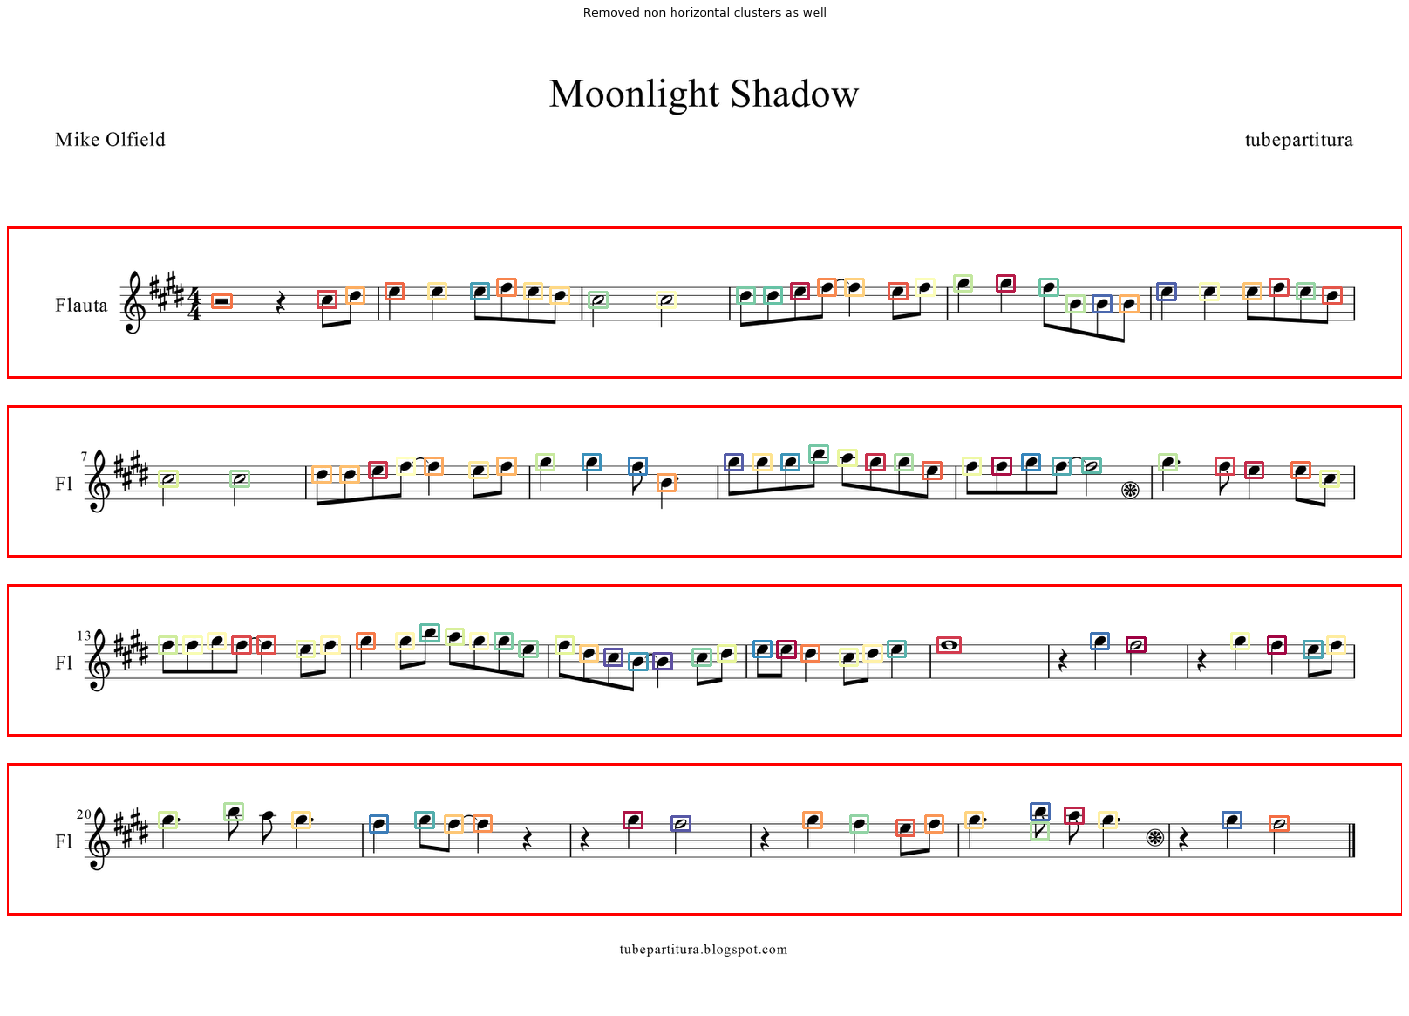

In [859]:
color_img = cv2.cvtColor(work_img, cv2.COLOR_GRAY2RGB)
colors = np.array([plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(aspect_filtered))])[:, :-1]*255
np.random.shuffle(colors)
    
       
padding = 2*line_thickness
for index, ((top, bottom, left, right), px) in enumerate(aspect_filtered):
    color = colors[index]
    cv2.rectangle(color_img, (left-padding, top-padding), (right+padding, bottom+padding), color, 2)
    
for top, bottom, left, right in interest_zones:
    cv2.rectangle(color_img, (left, top), (right, bottom), (255,0,0), 2)
    
display_img(color_img, title="Removed non horizontal clusters as well")   


# Note height evaluation

We need to make a grid in each interest zone to evaluate note height of detected notes now

In [860]:
lines_by_zone = [[] for i in range(len(interest_zones))]
for index, (top, bottom, _, _) in enumerate(interest_zones):
    for line in filtered_lines:
        if line[0] > top and line[0] < bottom:
            lines_by_zone[index].append(line[0])

In [861]:
base_full_notes = [0, 2, 4, 5, 7, 9, 11]
all_full_notes = sorted([note+i*12 for note in base_full_notes for i in range(10)])
F5_index = all_full_notes.index(77)

def get_lines_by_zone(interest_zones, identified_lines):
    lines_by_zone = [[] for i in range(len(interest_zones))]
    for index, (top, bottom, _, _) in enumerate(interest_zones):
        for line in filtered_lines:
            if line[0] > top and line[0] < bottom:
                lines_by_zone[index].append(line[0])
    return lines_by_zone

def get_grid_by_zone(interest_zones, identified_lines, spacer):
    lines_by_zone = get_lines_by_zone(interest_zones, identified_lines)
    
    for index, zone in enumerate(lines_by_zone):
        lines_above = []
        top_line = zone[0] - spacer
        while top_line > interest_zones[index][0]:
            lines_above.append(top_line)
            top_line = top_line - spacer

        lines_below = []
        bottom_line = zone[-1] + spacer
        while bottom_line < interest_zones[index][1]:
            lines_below.append(bottom_line)
            bottom_line = bottom_line + spacer

        lines_between = [(zone[i] + zone[i+1])/2 for i in range(len(zone)-1)]
        
        lines = sorted(np.array(lines_above + zone + lines_below + lines_between, dtype=np.int32))
        notes = [all_full_notes[F5_index+len(lines_above)-i] for i in range(len(lines))]
        
        lines_by_zone[index] = interest_zones[index], lines, notes
        
    return lines_by_zone
    

In [862]:
timer.start()
spacer = (line_spacing + line_thickness)/2

grid = get_grid_by_zone(interest_zones, filtered_lines, spacer)
    
timer.stop("Built grid to match notes in each zone")

Built grid to match notes in each zone - 0.73ms


In [863]:
color_img = cv2.cvtColor(work_img, cv2.COLOR_GRAY2RGB)
colors = np.array([plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(interest_zones))])[:, :-1]*255

timer.start()
for top, bottom, left, right in interest_zones:
    cv2.rectangle(color_img, (left, top), (right, bottom), (255,0,0), 2)
    
timer.lap("Drew zones")
for index, (zone, lines, _) in enumerate(grid):
    for line in lines:
        cv2.line(color_img,(0,line),(width,line),colors[index],2)
timer.stop("Drew lines")  

# display_img(color_img, title=f"Detected {len(centers)} interest zones")

Drew zones - 0.66ms
Drew lines - 3.31ms



Now, we would like to map a note to each line. to do this, we could in the grid-producing process, know that the first original line corresponds to the "F" on the top staff line. We did that, adding a note_range array returned, containing the MIDI codes of the notes corresponding to each line.

In [864]:
(t, b, l, r), px = aspect_filtered[0]
center = (b + t)/2, (r + l)/2

def get_zone_for_pixel(pixel, interest_zones):
    for index, zone in enumerate(interest_zones):
        if is_in_zone(pixel, zone):
            return index

zone_idx = get_zone_for_pixel(center, interest_zones)
zone, lines, notes = grid[zone_idx]

distances = [abs(center[0]-line)  for line in lines]
note_height = notes[np.argmin([abs(center[0]-line) for line in lines])]
note_height

79

In [865]:
NOTE_DURATION = 512
BETWEEN_NOTE_SPACE = 64

class Note:
    def __init__(self, height, rythm=2, velocity=60):
        self.height = height
        self.duration = int(NOTE_DURATION/rythm)
        self.velocity = velocity
        self.rythm = rythm
        
    def set_rythm(self, rythm):
        self.rythm = rythm
        self.duration = int(NOTE_DURATION/rythm)
        

In [866]:
# sort clusters by zone
clusters_by_zone = [[] for i in range(len(interest_zones))]
for cluster in aspect_filtered:
    (t, b, l, r), px = cluster
    center = (b + t)/2, (r + l)/2
    zone_idx = get_zone_for_pixel(center, interest_zones)
    zone, lines, notes = grid[zone_idx]
    distances = [abs(center[0]-line) for line in lines]
    note_height = notes[np.argmin(distances)]
    clusters_by_zone[zone_idx].append((cluster, Note(note_height)))

clusters_by_zone[0][0]

(((294, 304, 1090, 1102), array([[ 294, 1095],
         [ 294, 1096],
         [ 294, 1097],
         [ 294, 1098],
         [ 294, 1099],
         [ 294, 1100],
         [ 294, 1101],
         [ 295, 1094],
         [ 295, 1095],
         [ 295, 1096],
         [ 295, 1097],
         [ 295, 1098],
         [ 295, 1099],
         [ 295, 1100],
         [ 295, 1101],
         [ 295, 1102],
         [ 296, 1092],
         [ 296, 1093],
         [ 296, 1094],
         [ 296, 1095],
         [ 296, 1096],
         [ 296, 1097],
         [ 296, 1098],
         [ 296, 1099],
         [ 296, 1100],
         [ 296, 1101],
         [ 296, 1102],
         [ 297, 1092],
         [ 297, 1093],
         [ 297, 1094],
         [ 297, 1095],
         [ 297, 1096],
         [ 297, 1097],
         [ 297, 1098],
         [ 297, 1099],
         [ 297, 1100],
         [ 297, 1101],
         [ 297, 1102],
         [ 298, 1091],
         [ 298, 1092],
         [ 298, 1093],
         [ 298, 1094],
         [

In [867]:
clusters_by_zone = [sorted(c_zone, key=lambda x: x[0][0][2]) for c_zone in clusters_by_zone]
clusters_by_zone[0][0]

(((316, 323, 239, 253), array([[316, 241],
         [316, 242],
         [316, 243],
         [316, 244],
         [316, 245],
         [316, 246],
         [316, 247],
         [316, 248],
         [316, 249],
         [316, 250],
         [316, 251],
         [317, 239],
         [317, 240],
         [317, 241],
         [317, 242],
         [317, 243],
         [317, 244],
         [317, 245],
         [317, 246],
         [317, 247],
         [317, 248],
         [317, 249],
         [317, 250],
         [317, 251],
         [317, 252],
         [317, 253],
         [318, 239],
         [318, 240],
         [318, 241],
         [318, 242],
         [318, 243],
         [318, 244],
         [318, 245],
         [318, 246],
         [318, 247],
         [318, 248],
         [318, 249],
         [318, 250],
         [318, 251],
         [318, 252],
         [318, 253],
         [319, 239],
         [319, 240],
         [319, 241],
         [319, 242],
         [319, 243],
         [31

In [868]:
from mido import Message, MidiFile, MidiTrack

def save_notes_to_midi_files(clusters_by_zone):
    note_succession = [cluster[1] for zone in clusters_by_zone for cluster in zone ]

    mid = MidiFile()
    track = MidiTrack()
    mid.tracks.append(track)
    track.append(Message('program_change', program=12, time=0))

    for note in note_succession:
        track.append( Message('note_on',  note=note.height, time=BETWEEN_NOTE_SPACE) )    
        track.append( Message('note_off', note=note.height, time=note.duration)  )
        
    mid.save('new_song.mid')
    return note_succession

note_succession = save_notes_to_midi_files(clusters_by_zone)

In [869]:
import pygame   

freq = 44100    # audio CD quality
bitsize = -16   # unsigned 16 bit
channels = 2    # 1 is mono, 2 is stereo
buffer = 1024    # number of samples

def play_it():
    pygame.mixer.init(freq, bitsize, channels, buffer)

    pygame.mixer.music.load('new_song.mid')
    pygame.mixer.music.play()

def stop_it():
    pygame.mixer.music.stop()


In [870]:
play_it()

In [871]:
stop_it()

## Detecting rythm

In order to detect the rythm to play for each note (full, half, quarter, eights...) we will... Find an innovative method !

In [872]:
clusters_image = np.zeros_like(gray_img)
for zone in clusters_by_zone:
    for cluster in zone:
        cl, note = cluster
        _, pixels = cl
        for px in pixels:
            clusters_image[px[0], px[1]] = 1
    
# display_img(clusters_image, title="Visualizing only the notes")

### Differentiate full notes from white ones

To do this, we will compute the mean pixel density in a cluster. Clusters above mean are full notes, others are white ones.

In [873]:
def get_pixel_density(cluster):
    ((t,b,r,l), px), _ = cluster
    cluster_rect_size = (b-t)*(l-r)
    return len(px)/cluster_rect_size

In [874]:
densities = np.array([get_pixel_density(cluster) for zone in clusters_by_zone for cluster in zone])

mean_pixel_density = densities.mean()
median_pixel_density = (densities.max()+densities.min())/2

print(f"Pixel density | mean: {mean_pixel_density} | median: {median_pixel_density}")

Pixel density | mean: 0.9422197183998425 | median: 0.8304730983302412


In [875]:
# Assign note length to corresponding clusters
for zone in clusters_by_zone:
    for cluster in zone:
        _, note = cluster
        density = get_pixel_density(cluster)
        note.set_rythm(1 if density < median_pixel_density else 2)

### Differentiate "ronde" and "blanche" 

Don't know how to call these in english... I will try to differentiate them through the aspect ratio of the clusters. I will compute all aspect ratios, try out mean and median values to differentiate, and see which works best.

In [876]:
def get_cluster_length(cluster):
    ((t,b,r,l), _), _ = cluster
    return (l-r)

In [877]:
cluster_lengths = np.array([get_cluster_length(cluster) for zone in clusters_by_zone for cluster in zone])

mean_cluster_length = cluster_lengths.mean()
median_cluster_length = (cluster_lengths.max()+cluster_lengths.min())/2
most_cluster_length = Counter(cluster_lengths).most_common(2)

print(f"Aspect ratio | mean: {mean_cluster_length} | median: {median_cluster_length} | most common: {most_cluster_length}")


Aspect ratio | mean: 12.521739130434783 | median: 15.0 | most common: [(12, 61), (13, 52)]


In [878]:
# Assign note length to corresponding clusters
for zone in clusters_by_zone:
    for cluster in zone:
        _, note = cluster
        cluster_l = get_cluster_length(cluster)
        if note.rythm <= 1:
            note.set_rythm(1 if cluster_l < median_cluster_length else 0.5)
            print(note.rythm, cluster_l)


1 13
1 13
1 13
1 13
1 13
0.5 18
1 13
1 13
1 12
1 13


In [879]:
note_succession = save_notes_to_midi_files(clusters_by_zone)


In [880]:
play_it()

In [881]:
stop_it()

In [882]:
x, y = gray_img.shape
aspect_ratio_image = np.ones((x, y, 3))
for zone in clusters_by_zone:
    for cluster in zone:
        cl, note = cluster
        _, pixels = cl
        for px in pixels:
            if note.rythm == 2:
                aspect_ratio_image[px[0], px[1]] = (0, 0, 1)
            elif note.rythm == 0.5:
                aspect_ratio_image[px[0], px[1]] = (0, 1, 0)
            else:
                aspect_ratio_image[px[0], px[1]] = (1, 0, 0)
# display_img(aspect_ratio_image, title="Visualizing detected full or empty notes")

In [883]:
note_zones = []

for index, zone in enumerate(clusters_by_zone):
    left_right = np.array([(l, r) for (((t,b,l,r), px), note) in zone])
    
    left = left_right.min() - line_spacing
    top = interest_zones[index][0]
    bottom = interest_zones[index][1]
    note_zones.append((top, bottom, left, width))


In [884]:
Y = get_black_pixels_in_interest_zones(no_staff_line_image, note_zones) 

In [885]:
timer.start()
db = DBSCAN(eps=line_spacing, min_samples=10).fit(Y)

labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

timer.stop('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 102 - 452.48ms
Estimated number of noise points: 0


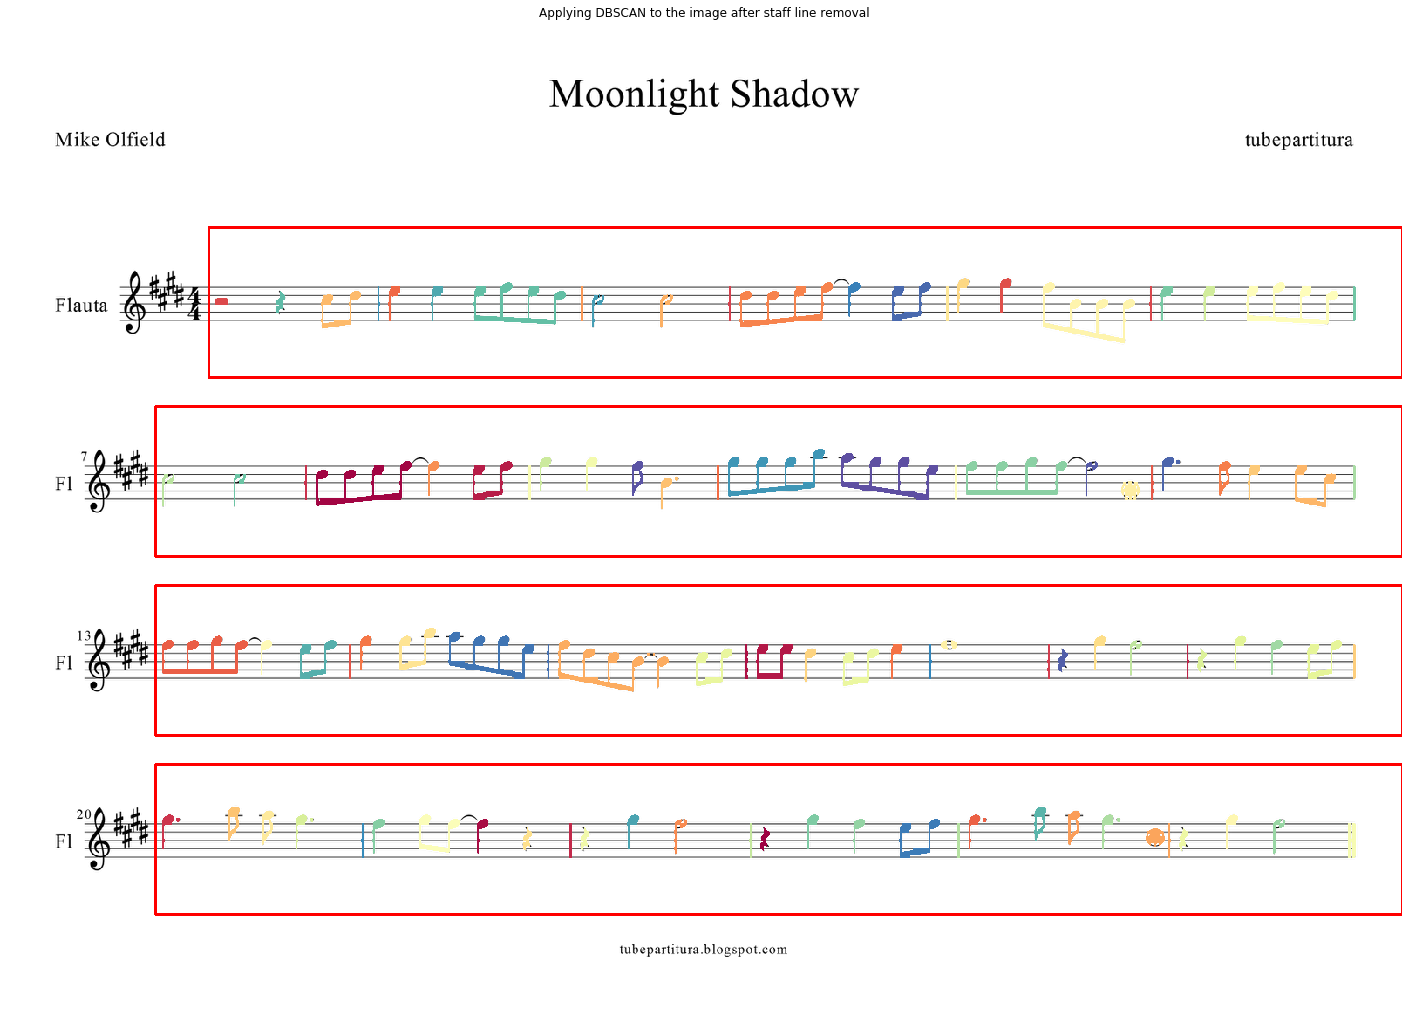

In [886]:
color_img = cv2.cvtColor(work_img, cv2.COLOR_GRAY2RGB)

colors = np.array([plt.cm.Spectral(each)
          for each in np.linspace(0, 1, n_clusters_)])[:, :-1]*255
np.random.shuffle(colors)

for index, label in enumerate(labels):
    color_img[Y[index][0], Y[index][1]] = colors[label]
    
for top, bottom, left, right in note_zones:
    cv2.rectangle(color_img, (left, top), (right, bottom), (255,0,0), 2)
    
    
display_img(color_img, title="Applying DBSCAN to the image after staff line removal")

In [566]:
no_note_image = no_staff_line_image + clusters_image

#display_img(no_note_image, title="Visualizing image without the notes")